<a href="https://colab.research.google.com/github/Ariadna51/Coursera_Capstone/blob/master/Representing_Horizontal_Eye_Position.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to use this tutorial:

You are expected to read this document sequentially, and answer questions you will find in the comments and at the bottom of the document. You will present your answers at our next encounter.

To edit, go to File> Save a Copy in Drive or File > Open in Playground Mode


# Tutorial: Representing Eye Position in Populations of Spiking Neurons

In this [colab](https://colab.research.google.com/notebooks/intro.ipynb) we will use the simulator [NENGO](www.nengo.ai) to implement a neural population of leaky integrate and fire neurons that represents eye position (a continuous variable). This is an ultra simple example for you to **get a sense of what it means for populations of neurons to encode physical quantities**.

We will **create a population of encoding neurons**, which effectively will be basis functions, and will respond monotonically but non-linearly. 

The response of these LIF neurons are derived from response properties found  in the NPH and MVN, which have tuning curves for specific eye positions.

We will then **decode the eye position information** from the population of neurons. We will then verify the quality of the decoding and observe how it changes with the size of the neural population and other biophysical properties of the modeled neurons such as membrane time constant.


# Learning Goals

- Learn how to implement a LIF network in Nengo
- Probe and display network inputs and outputs
- Encode an input quantity in a LIF population
- Decode the quantity from these LIF neurons
- Change properties of Networks, LIF neurons and synapses


For reference code snippets check: https://www.nengo.ai/nengo/examples/advanced/nef-summary.html

# Requirements

- [some notion of object oriented programming](https://www.youtube.com/watch?v=pTB0EiLXUC8).

# Glossary

- **Input space**: the set of possible values that input can take. For example, the input space of a single photo receptor is the possible luminance values that the photosensor receives.

# Initialization

In the cells below we install the nengo simulator and import relevant python packages.

In [1]:
# Install Nengo into the colab via pip
!pip install nengo

     |████████████████████████████████| 532kB 7.9MB/s 


In [2]:
import nengo # our simulator
import pandas as pd # to collect and handle data frames
import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical / mathematical functions
import seaborn as sns # for nice plotting

In [3]:
%matplotlib inline

from nengo.dists import Uniform # a nice uniform distribution
from nengo.processes import WhiteSignal # a noise source
from nengo.utils.ensemble import tuning_curves # tuning curves
# from nengo.utils.ipython import hide_input 
from nengo.utils.matplotlib import rasterplot # for a convenient way of displaying raster plots

# Modeling in Nengo

A recipe for a model in Nengo is as follows:

1. Create a model with `nengo.Network()` object.
2. Create and insert inputs in the model via `nengo.Node()`.
3. Add a number of neuronal populations via `nengo.Ensembles()`. Here we can also set the properties of our neurons, such as membrane time constant.
4. Connect those ensembles via synapses via `nengo.Connection(). Here we can also define synaptic properties. It is here as well, that we may want to define the **decoding functions**.
5. Add the model to a `nengo.Simulator()` object and run.
6. Plot selected variables using your package of choice (e.g., seaborn, matplotlib).


## 1. Create a model.

This is the **object** that we will populate with inputs, neurons and probes, and that we will simulate.

In [4]:
model = nengo.Network(label='NPH and VN') # Label is simply a name (string)

## 2. Create an input:

Nengo's function `Node()` is used to create inputs to networks. [Lambda notation](https://realpython.com/python-lambda/) is often used for the purpose. 

- a function that returns a ramping input

> `input = nengo.Node(lambda t: t * 2 - 1)`

- a function that returns 1 during a certain interval.

> `input = nengo.Node(lambda t: [1, 0] if t < 0.1 else [0, 0])`

- a function that produces a sine wave with a certain frequency

> `input = nengo.Node(lambda t: sin(2*pi*t)`

- combine the two last statements

`input = nengo.Node(lambda t: sin(2*pi*t) if t > 1 else [0, 0])`

In [5]:
with model: # to add things to model, we use 'with' 
  input = nengo.Node(lambda t: np.sin(2*1*np.pi * t)) # the input 
  # input = nengo.Node(lambda t: t * 2 - 1) # the input 
  input_probe = nengo.Probe(input) # with Probe we record a variable

In order to display our input, we need to run the model (this populates the output variables). We do that by adding our model to `Simulator()` on `model`  and running for `t` seconds.

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Our model only has an input so far, no neurons. But we can plot it for sanity checking:

(0.0, 2.0)

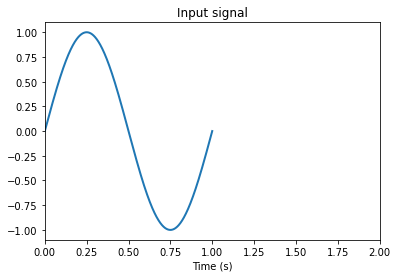

In [8]:
plt.figure()
plt.plot(sim.trange(), sim.data[input_probe], lw=2) #note 'input_probe' is what we created above. lw is line width.  
plt.title("Input signal")
plt.xlabel("Time (s)")
plt.xlim(0, 2)

## 3. Create some Neurons that Cover the Input Space

We will add an ensemble that encodes a continuous variable (representing some physical input to sensory neurons). We do this by creating a set of neurons, each of which has a different tuning curve, such that they 'cover' the entire 'input space'. These tuning curves will have a mostly-linear relationship with an encoded quantity. In NENGO we refer to neurons with tuning curves as  'encoders'.

---

Firing characteristics of the Nucleus Prepositus Hipoglossi and Medial Vestibular Nucleus

**System Specification:**
> 
- Encode for horizontal eye position -- 
  - Humans: 50deg horizontal eye motion (Davson 1990, p.657).
  - In the model we can transform this to a range between [-1, 1], without loss of generality!
- Background firing rates in the NPH: 0-150 Hz (Moschovakis 1997)
- Maximum firing rate ~ 300Hz
- Tuning curve sensitivities (mostly linear!) : 0.1 to 7 Hz / deg





---

### Tuning curves as basis functions
Distribute the encoders over the encoded space by setting neurons with intercepts that cover the encoded dimension e.g., from [-1 to 1]. We do this with a helper function `aligned()`, defined below. We will use the output of this function to parameterize our encoding neurons.

Example: Write a fuction called 'aligned', that returns two lists of N values, where:
- **intercepts**: the value at which the neuron starts firing. Equally spaced points in an interval between [-radius, radius], where radius represents the possible values of an input around zero. 
- **encoders**: the slope of the tuning curves of the neuron. Here we simply use a vector populated with equal numbers of -1 (off neurons) and 1 (on neurons). The reasons for this choice are explained in Neuroengineering chapter 4).


In [9]:
def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons)
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1))
    intercepts *= encoders[:, 0]
    return intercepts, encoders

#### Warm-up Exercise:
**Call the function** defined above with 8 neurons and a radius of 1 and **inspect the output**.

In [17]:
# your code here
intercepts, encoders = aligned(8, 1)

### Check your answer below

In [18]:
intercepts, encoders = aligned(8, .9)

### Make an IF population of encoders

Below we create an ensemble of 8 IF neurons to encode the 1-dimensional input (e.g., the eye position) according to specified intercepts, encoders and with specified max_rates.

In [20]:
with model:
    NPH = nengo.Ensemble( #NPH stands for 'nucleus prepositus hipoglossi'
        8,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(80, 100), # the maximum firing rate of the neurons are drawn from the uniform distribution
        encoders=encoders,
    )

We can plot the tuning curves of our neurons, with the function `tuning_curves` for population A

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0, 0.5, 'Firing rate (Hz)')

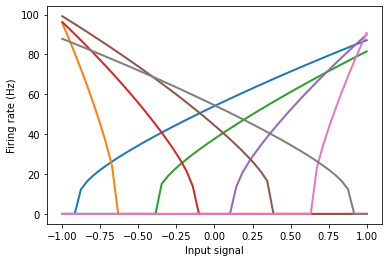

In [21]:
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(NPH, sim) 

plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)")

### 5. Connect the Inputs with Neurons

We distribute the input to all neurons in the ensemble via `nengo.Connection()`. By default we connect the input to all postsynaptic neurons with equal weights*. Let's also create a probe for the spikes the model is producing.

In [22]:
with model:
    nengo.Connection(input, NPH)
    NPH_spikes = nengo.Probe(NPH.neurons)

### 5. Run the Network

In [23]:
with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

## 6. How do the activity of the neurons looks like??

Now that we have the encoding neurons, the input and the probes, we can run the simulation and check the firing behavior of the neurons.

#### Raster Plot:

Text(0.5, 0, 'Time (s)')

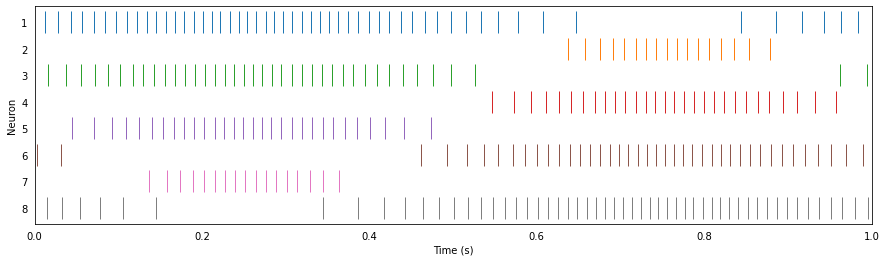

In [ ]:
plt.figure(figsize=[15,4])
ax = plt.subplot(1, 1, 1)
rasterplot(sim.trange(), sim.data[NPH_spikes], ax)
ax.set_xlim(0, 1)
ax.set_ylabel("Neuron")
ax.set_xlabel("Time (s)")

#### Membrane Potential

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

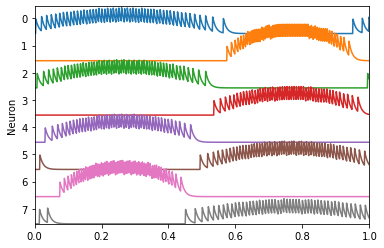

In [24]:
with model:
  nengo.Connection(input, NPH)
  NPH_spikes = nengo.Probe(NPH.neurons, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(1)

scale = 180
plt.figure()
for i in range(NPH.n_neurons):
    plt.plot(sim.trange(), sim.data[NPH_spikes][:, i] - i * scale)
plt.xlim(0, 1)
plt.ylim(scale * (-NPH.n_neurons + 1), scale)
plt.ylabel("Neuron");
plt.yticks(
    np.arange(scale / 1.8, (-NPH.n_neurons + 1) * scale, -scale), np.arange(NPH.n_neurons)
);

## 7. Check your decoding skills!


Can we decode those spikes and obtain our signal back? A decoder that produces the identity function can be obtained via a simple Probe. To find the decoding weights, the probe of a population uses the encoded value.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(0.0, 5.0)

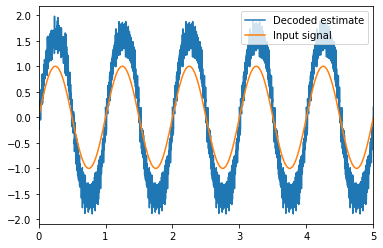

In [ ]:
with model:
    NPH_probe = nengo.Probe(NPH, synapse=0.01)  # 10ms PSC filter (AMPA like)


with nengo.Simulator(model) as sim:
    sim.run(simtime)

plt.figure()
plt.plot(sim.trange(), sim.data[NPH_probe], label="Decoded estimate")
plt.plot(sim.trange(), sim.data[input_probe], label="Input signal")
plt.legend(loc="best")
plt.xlim(0, simtime)

# Exercises

Exercise 1. Verify that the parameters of our network are specified according to the experimental data. Particularly, make sure that the values for individual neuronal tuning curves in the code above are correctly specified in the introduction.

Exercise 2. Change the frequency of the sinusoidal input function and inspect the decoding quality. Are all frequencies decoded equally well?

Exercise 3. Our network is rather small. Change the number of neurons and observe the impact on decoding quality.

Exercise 4. Create an 'efference copy' from the encoding population. That is: produce another population downstream from the encoding population that conveys the same 'quantity' (same number of dimensions). Now decode the original value from the second population. What do you observe?


# Bonus: Influence of Membrane Time Constant on Signal Reconstruction

Code gracefully scraped from: https://github.com/ctn-waterloo/modelling_ideas/issues/91

In [ ]:
def go(freq, tau_rc, n_neurons=10, tau_probe=0.005, t=1.0, dt=0.001, seed=0):
    with nengo.Network() as model:
        u = nengo.Node(output=lambda t: np.sin(2*np.pi*freq*t))
        x = nengo.Ensemble(n_neurons, 1, seed=seed,
                           neuron_type=nengo.LIF(tau_rc=tau_rc))
        nengo.Connection(u, x, synapse=None)
        
        p_u = nengo.Probe(u, synapse=tau_probe)
        p_x = nengo.Probe(x, synapse=tau_probe)
        
    with nengo.Simulator(model, dt=dt, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
        
    return nengo.utils.numpy.rmse(sim.data[p_u], sim.data[p_x])

data = []
for seed in range(5):
    for freq in np.linspace(0, 50, 20):
        for tau_rc in [0.001, 0.005, 0.01, 0.02, 0.1]:
            print(freq, tau_rc)
            data.append((freq, tau_rc, seed, go(freq, tau_rc, seed=seed)))
df = pd.DataFrame(data, columns=("Frequency", "tau_rc", "Seed", "RMSE"))

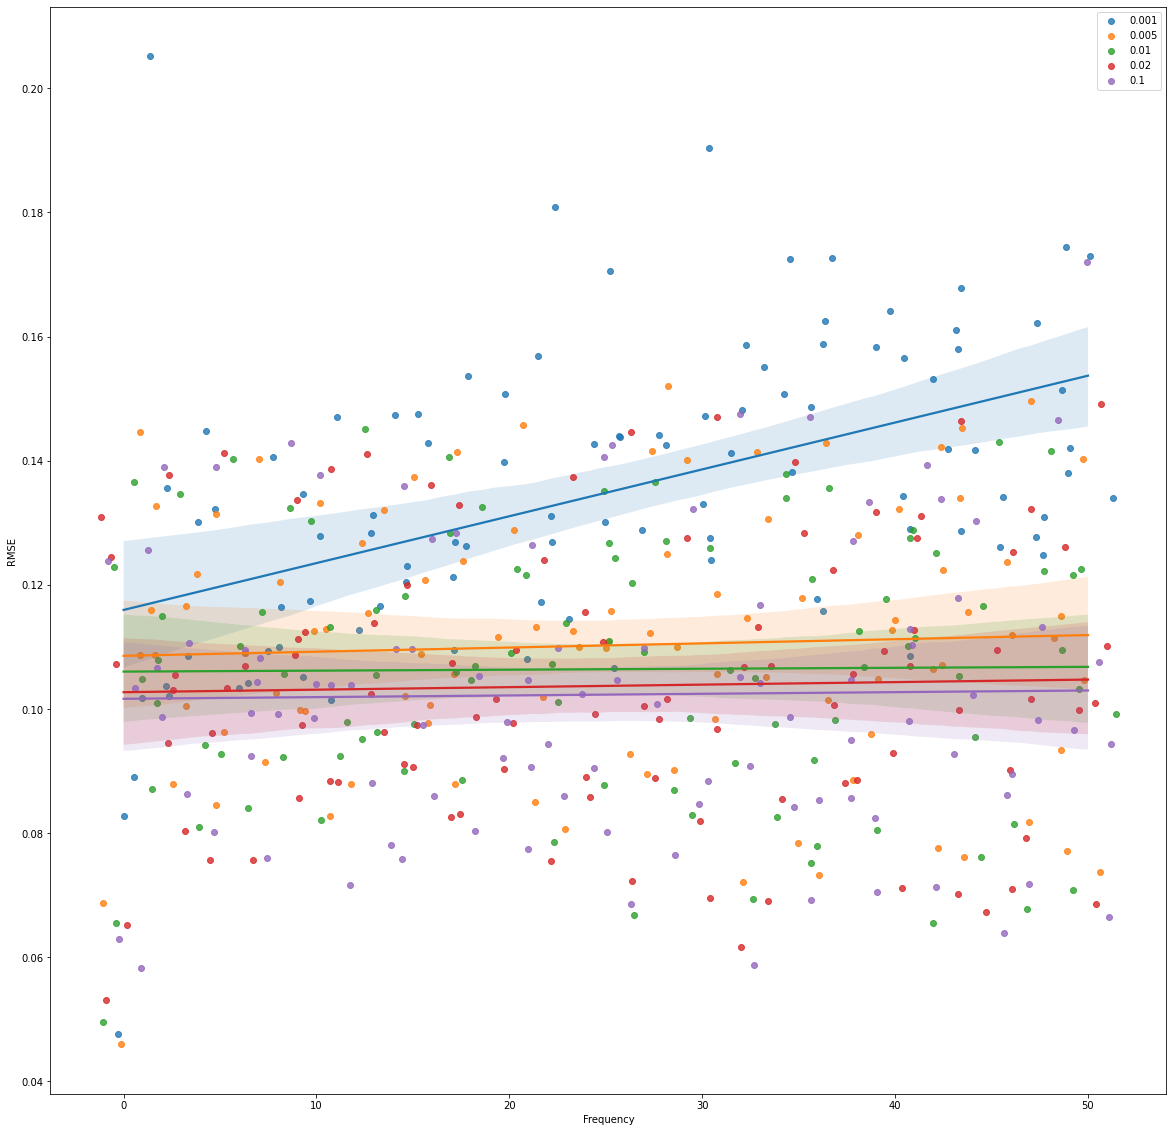

In [ ]:
plt.figure(figsize=[20,20])
for tau_rc in df.tau_rc.unique():
    sns.regplot(data=df[df['tau_rc'] == tau_rc], x_jitter=1.5,
                x="Frequency", y="RMSE", label=str(tau_rc))
plt.legend()
plt.show()